In [69]:
## first softmax version
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
# Cell 1: Import the module
from gp_softmax_torch_works_play import *
## first softmax version
%load_ext autoreload
%autoreload 2
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Generate synthetic data
N = 100  # Number of individuals
D = 5    # Number of diseases
T = 50   # Number of time points
K = 3    # Number of topics
P = 5    # Number of genetic covariates
torch.manual_seed(42)
np.random.seed(42)
# 1. Generate synthetic data with true parameters
true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)
Y = true_data['Y']
G = true_data['G']
prevalence = true_data['prevalence']
event_times = true_data['event_times']
true_pi = true_data['pi']

# Initialize the model
model = AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence)



Epoch 0
Loss: 9654.4219
Length scales: [16.665667 16.665667 16.665667]
Amplitudes: [1.0010005 1.0010005 1.0010005]
Max gradients - λ: 60.8843, φ: 53.6663, γ: 32.0120
Mean condition number: 9847.14

Epoch 10
Loss: 5213.6924
Length scales: [16.655586 16.655584 16.6556  ]
Amplitudes: [1.0111578 1.0111588 1.0111569]
Max gradients - λ: 29.9919, φ: 25.5484, γ: 29.0627
Mean condition number: 5022.13

Epoch 20
Loss: 4495.6006
Length scales: [16.64509  16.645077 16.64518 ]
Amplitudes: [1.0219766 1.0219882 1.0219712]
Max gradients - λ: 28.6632, φ: 24.2326, γ: 25.9653
Mean condition number: 5127.98

Epoch 30
Loss: 3942.3599
Length scales: [16.634504 16.634455 16.634691]
Amplitudes: [1.0331136 1.0331483 1.0331106]
Max gradients - λ: 27.1253, φ: 22.8149, γ: 23.7106
Mean condition number: 5238.13

Epoch 40
Loss: 3515.3660
Length scales: [16.623919 16.62381  16.6242  ]
Amplitudes: [1.0444679 1.0445423 1.0444846]
Max gradients - λ: 25.4919, φ: 21.3383, γ: 21.3820
Mean condition number: 5351.97

Epoch

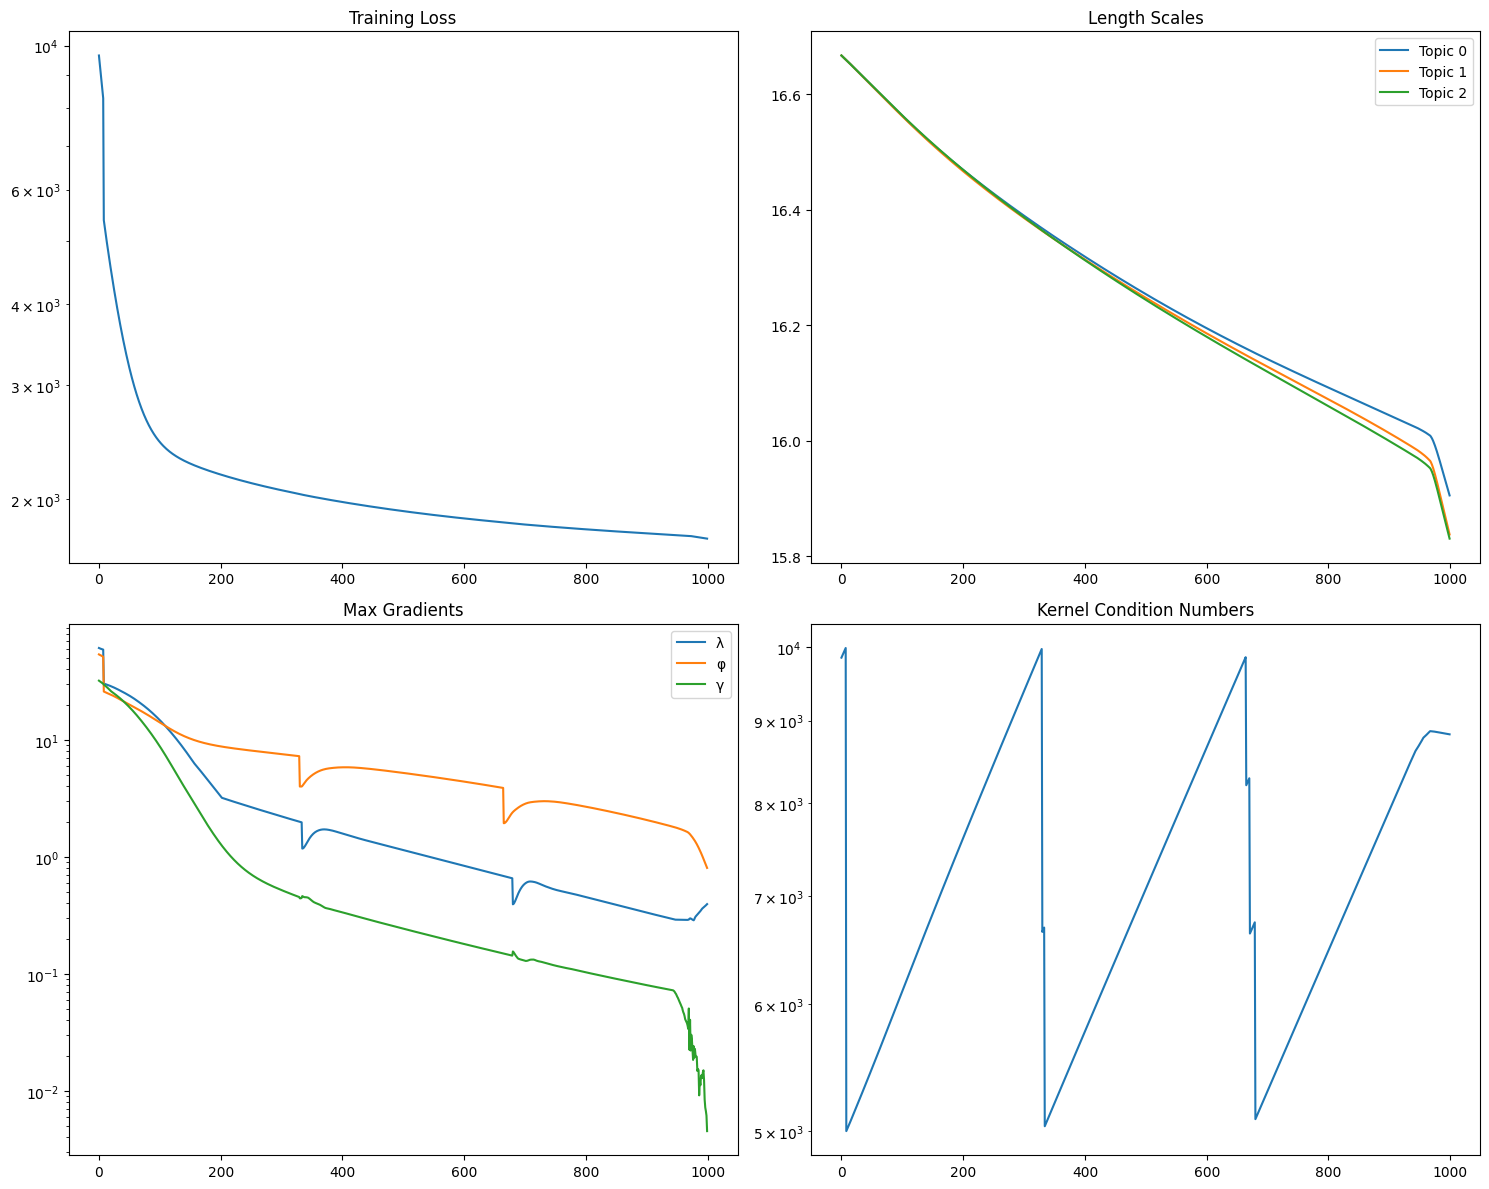

In [60]:

# Fit the model
num_epochs = 100
learning_rate = 1e-3
lambda_reg = 1e-2  # L2 regularization weight for gamma

history = model.fit(event_times, num_epochs=1000)
plot_training_diagnostics(history)




In [61]:

# 4. Get model predictions
pi_pred, theta_pred, phi_pred = model.forward()



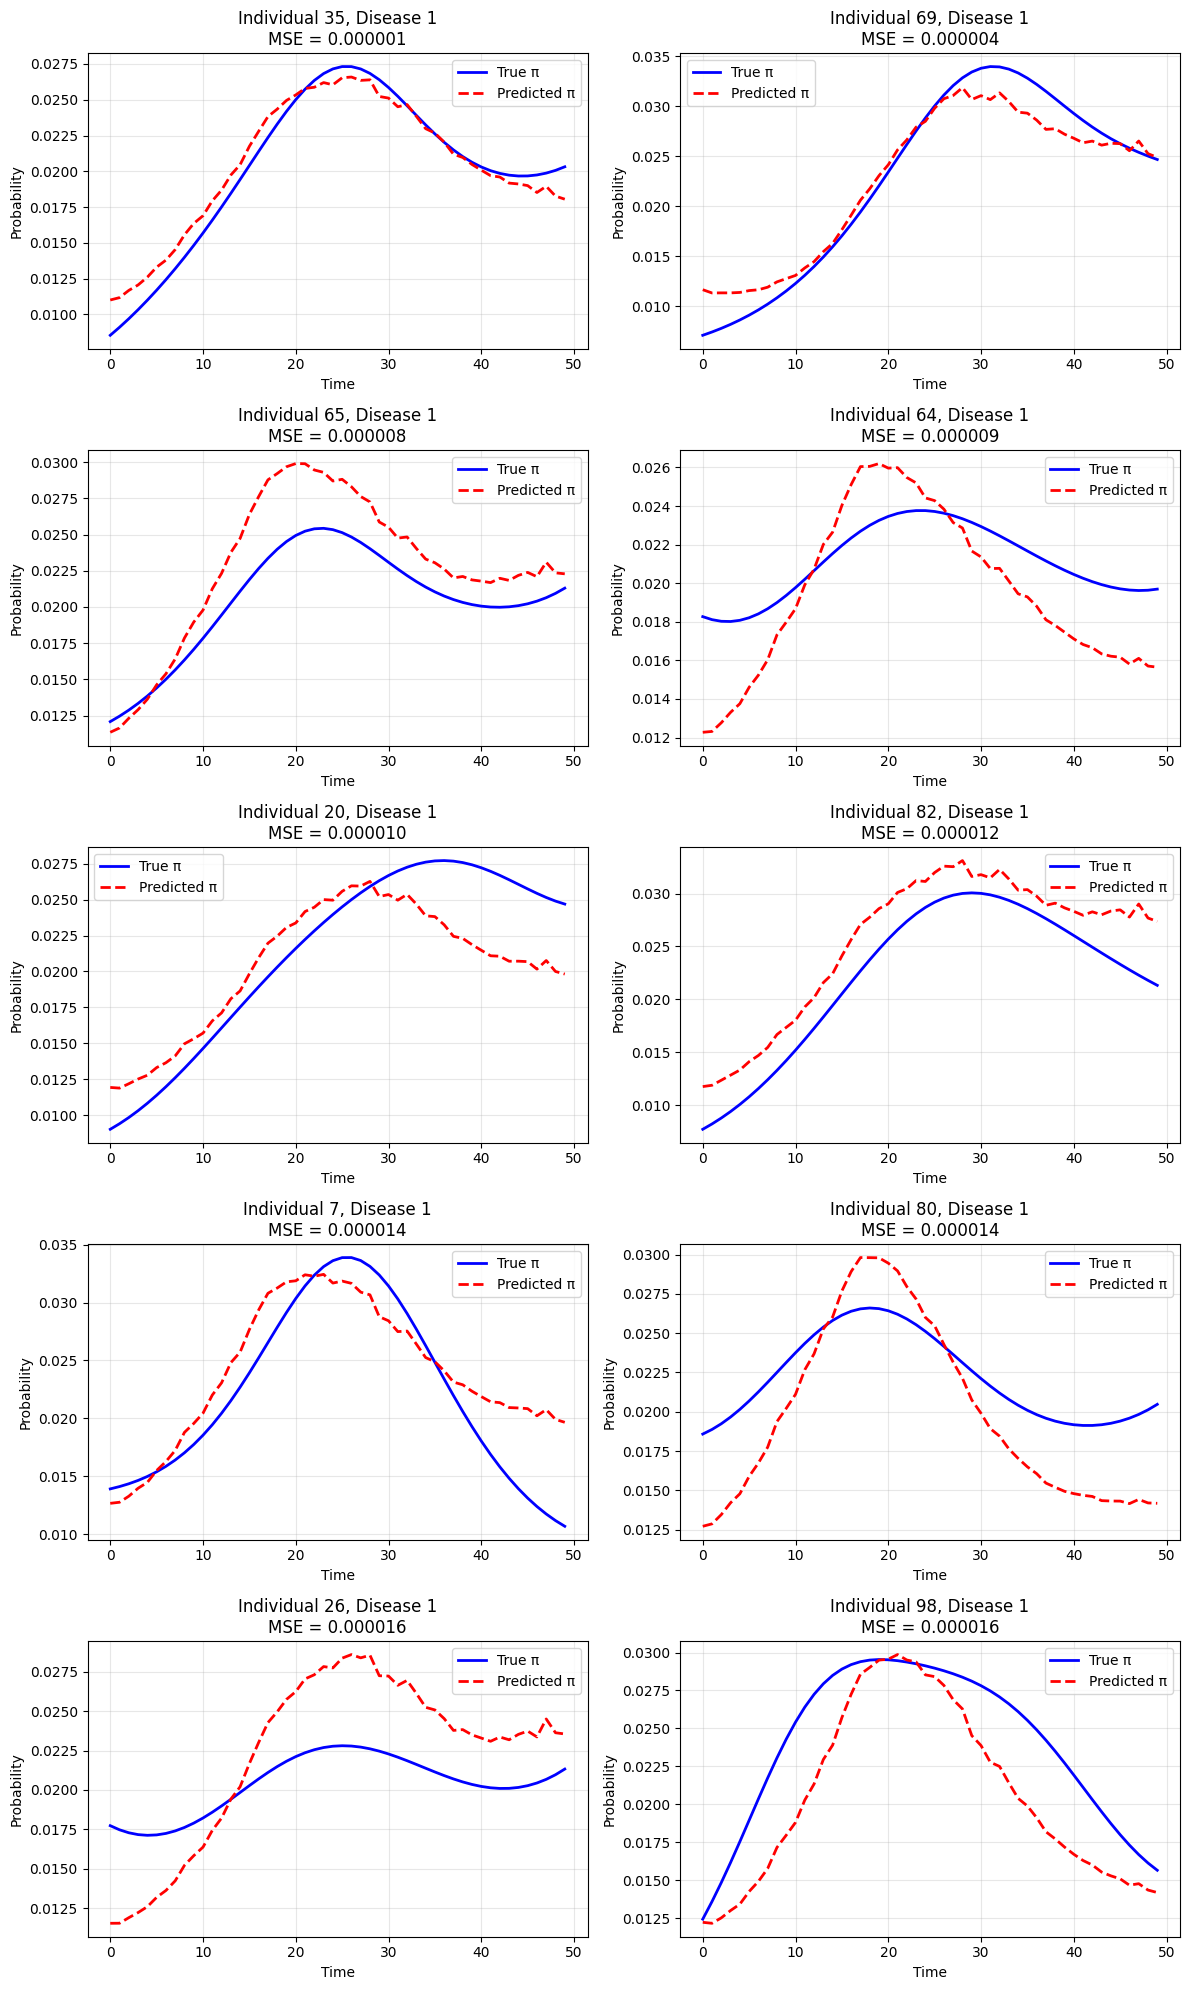

In [62]:

pi_pred, theta_pred, phi_pred = model.forward()
plot_best_matches(true_pi, pi_pred, n_samples=10, n_cols=2)


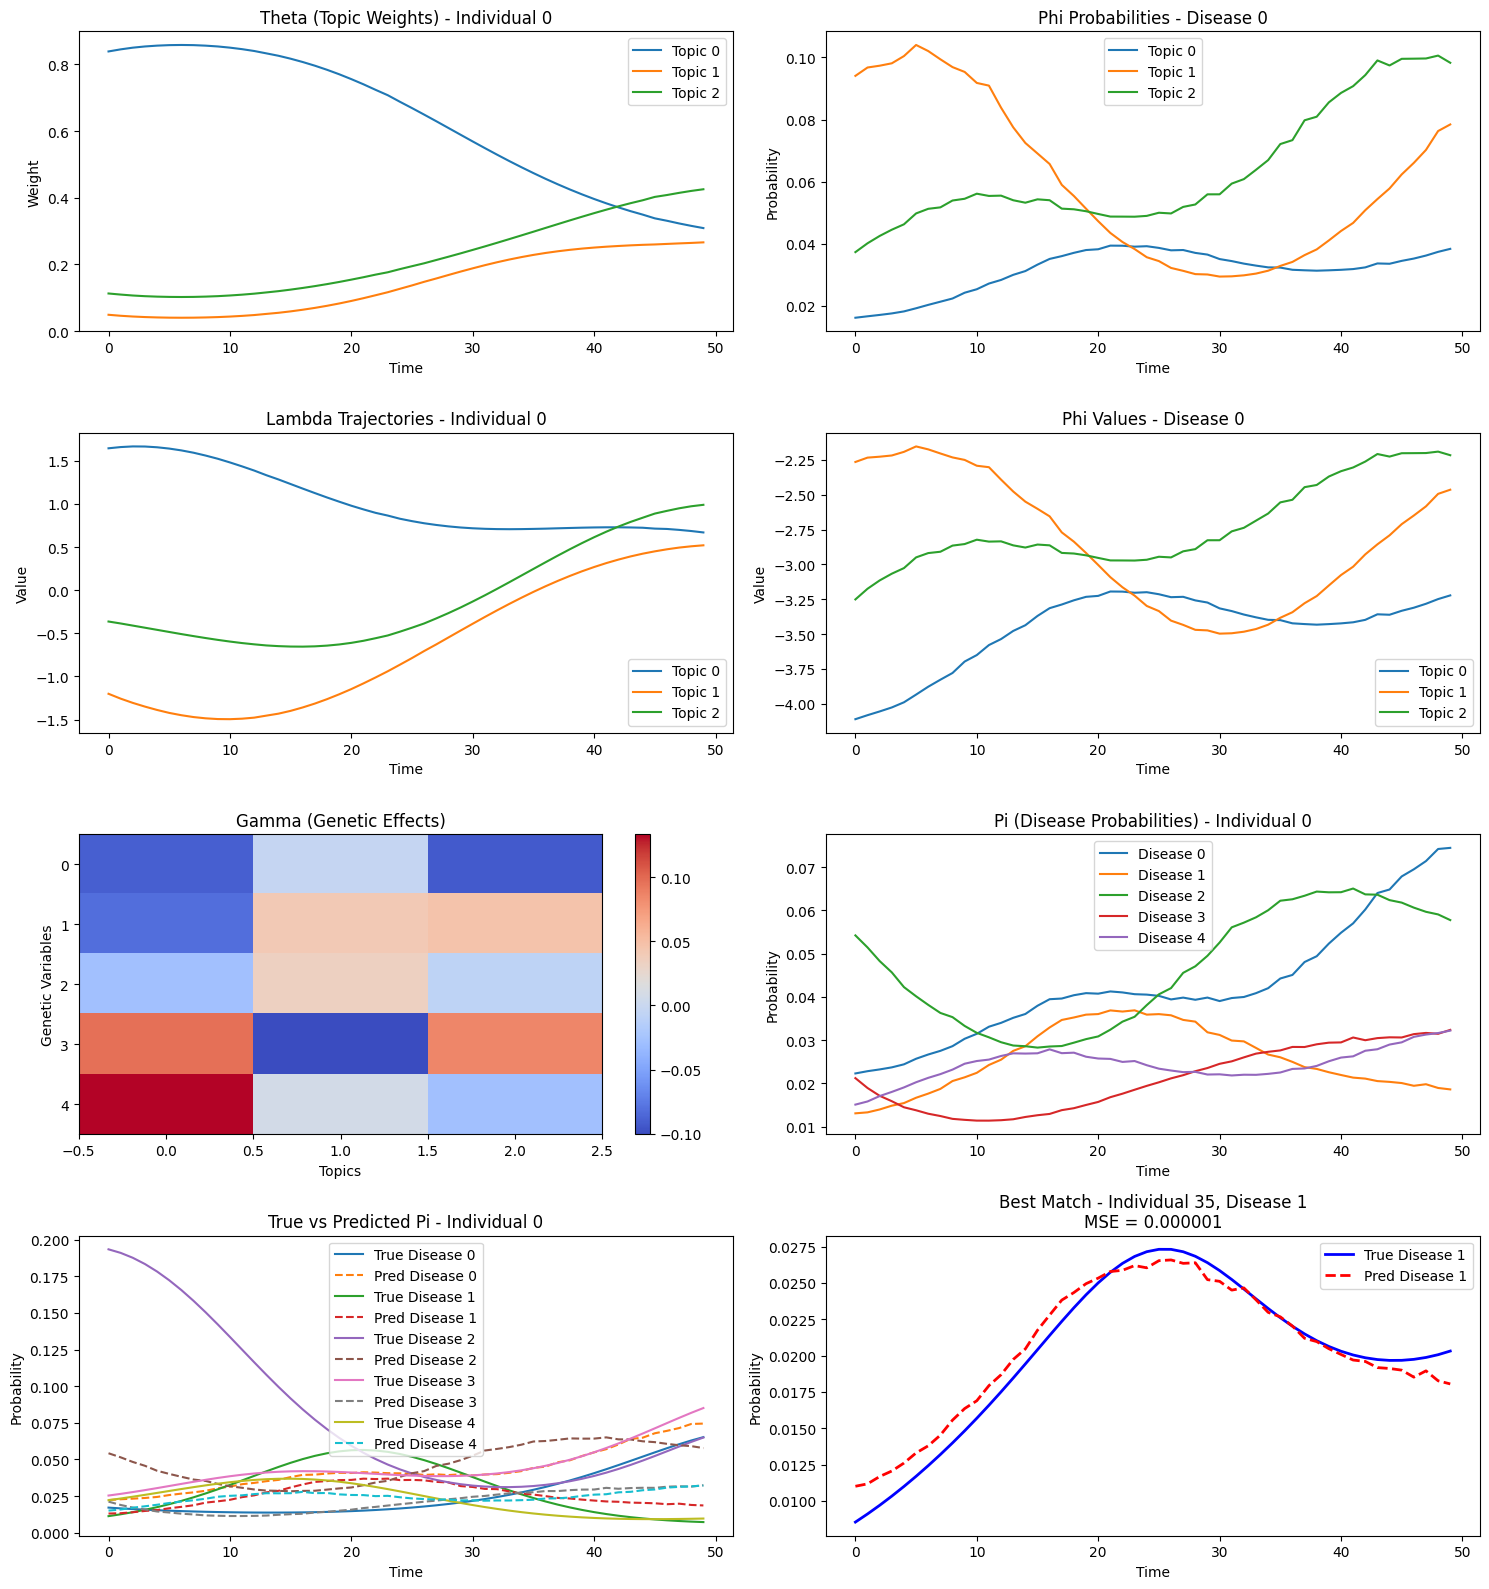

In [63]:
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(4, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()

for d in range(D):
    axes[3, 0].plot(true_pi[0, d, :], '-', label=f'True Disease {d}')
    axes[3, 0].plot(pi_pred_np[0, d, :], '--', label=f'Pred Disease {d}')
axes[3, 0].set_title('True vs Predicted Pi - Individual 0')
axes[3, 0].set_xlabel('Time')
axes[3, 0].set_ylabel('Probability')
axes[3, 0].legend()

# 8. Plot true vs predicted pi for a good match
# Find a good matching individual-disease pair
mse = np.mean((true_pi - pi_pred_np)**2, axis=2)  # N×D
best_idx = np.unravel_index(np.argmin(mse), mse.shape)
i_best, d_best = best_idx

axes[3, 1].plot(true_pi[i_best, d_best, :], 'b-', 
                label=f'True Disease {d_best}', linewidth=2)
axes[3, 1].plot(pi_pred_np[i_best, d_best, :], 'r--', 
                label=f'Pred Disease {d_best}', linewidth=2)
axes[3, 1].set_title(f'Best Match - Individual {i_best}, Disease {d_best}\nMSE = {mse[i_best, d_best]:.6f}')
axes[3, 1].set_xlabel('Time')
axes[3, 1].set_ylabel('Probability')
axes[3, 1].legend()

plt.tight_layout()
plt.show()



In [64]:
def plot_all_pi_comparison(true_pi, pred_pi):
    """
    Plot all predicted vs true pi values
    
    Parameters:
    true_pi: numpy array (N×D×T)
    pred_pi: torch tensor (N×D×T)
    """
    # Convert to numpy and flatten
    pred_pi_np = pred_pi.detach().numpy()
    true_flat = true_pi.flatten()
    pred_flat = pred_pi_np.flatten()
    
    # Create plot
    plt.figure(figsize=(10, 10))
    
    # Scatter plot
    plt.scatter(true_flat, pred_flat, alpha=0.1, color='blue')
    
    # Add diagonal line
    max_val = max(true_flat.max(), pred_flat.max())
    min_val = min(true_flat.min(), pred_flat.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    
    # Add correlation coefficient
    corr = np.corrcoef(true_flat, pred_flat)[0,1]
    mse = np.mean((true_flat - pred_flat)**2)
    
    plt.title(f'True vs Predicted π\nR: {corr:.3f}, MSE: {mse:.6f}')
    plt.xlabel('True π')
    plt.ylabel('Predicted π')
    plt.legend()
    
    # Make plot square
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()



Epoch 0
Loss: 9902.3096
Length scales: [16.665667 16.665667 16.665667]
Amplitudes: [1.0010005 1.0010005 1.0010005]
Max gradients - λ: 69.7086, φ: 63.8296, γ: 22.2800
Mean condition number: 9847.14

Epoch 10
Loss: 5429.6226
Length scales: [16.655588 16.655588 16.655588]
Amplitudes: [1.0111587 1.011157  1.0111579]
Max gradients - λ: 32.7938, φ: 30.2310, γ: 22.8457
Mean condition number: 5022.16

Epoch 20
Loss: 4705.1704
Length scales: [16.645103 16.645103 16.645103]
Amplitudes: [1.0219835 1.0219665 1.0219743]
Max gradients - λ: 30.7617, φ: 28.5205, γ: 21.3807
Mean condition number: 5127.78

Epoch 30
Loss: 4147.6304
Length scales: [16.634521 16.634508 16.634525]
Amplitudes: [1.0331362 1.0330931 1.0331092]
Max gradients - λ: 28.7885, φ: 26.8856, γ: 19.8590
Mean condition number: 5238.06

Epoch 40
Loss: 3717.4756
Length scales: [16.623917 16.623886 16.623953]
Amplitudes: [1.0445203 1.0444419 1.0444621]
Max gradients - λ: 26.7500, φ: 25.2462, γ: 18.2880
Mean condition number: 5351.73

Epoch

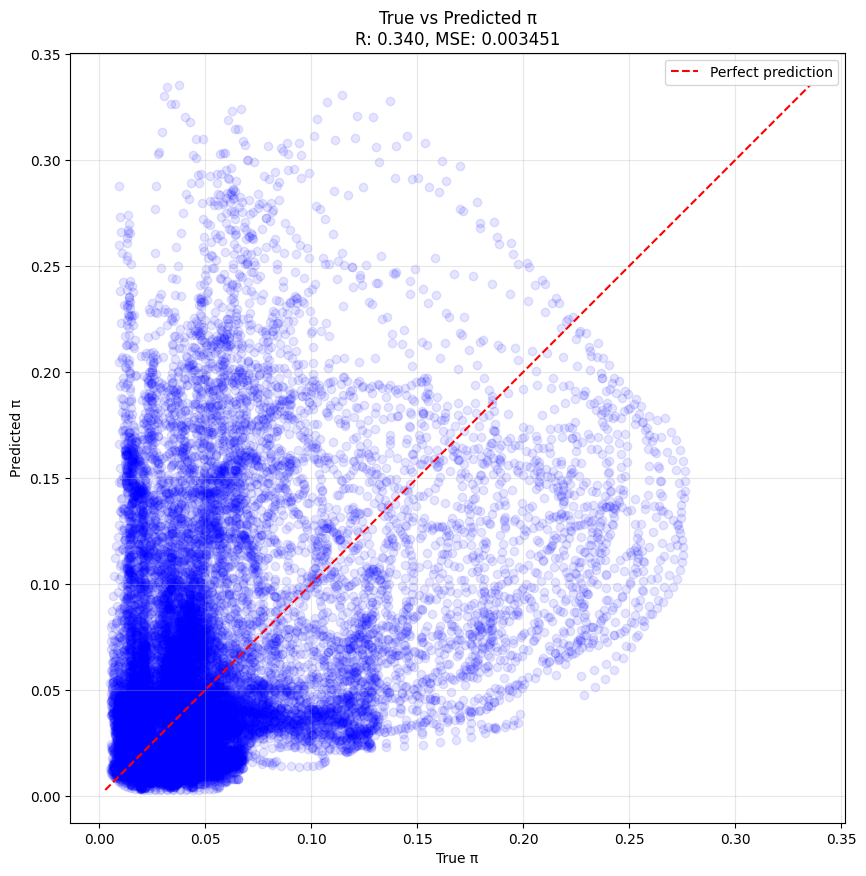

In [67]:
# Generate synthetic data
N = 100  # Number of individuals
D = 5    # Number of diseases
T = 50   # Number of time points
K = 3    # Number of topics
P = 5    # Number of genetic covariates


true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)
Y = true_data['Y']
G = true_data['G']
prevalence = true_data['prevalence']
event_times = true_data['event_times']
true_pi = true_data['pi']

# 2. Initialize model
model = AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence)

# 3. Fit model
losses = model.fit(event_times, num_epochs=100)

# 4. Get model predictions
pi_pred, theta_pred, phi_pred = model.forward()

plot_all_pi_comparison(true_pi, pi_pred)


In [68]:
def plot_phi_heatmaps(phi_pred, K, D, T):
    """
    Plot heatmaps of phi values for each topic
    
    Parameters:
    phi_pred: torch tensor (K×D×T)
    K: number of topics
    D: number of diseases
    T: number of time points
    """
    phi_np = phi_pred.detach().numpy()
    
    # Create subplot grid
    fig, axes = plt.subplots(K, 1, figsize=(12, 4*K))
    if K == 1:
        axes = [axes]
    
    for k in range(K):
        # Create heatmap for topic k
        im = axes[k].imshow(phi_np[k], aspect='auto', cmap='RdBu_r')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[k])
        
        # Add labels
        axes[k].set_title(f'Topic {k} Disease Patterns')
        axes[k].set_xlabel('Time')
        axes[k].set_ylabel('Disease')
        
        # Add disease numbers
        axes[k].set_yticks(range(D))
        axes[k].set_yticklabels([f'Disease {d}' for d in range(D)])
        
        # Add time ticks
        time_ticks = np.linspace(0, T-1, 5, dtype=int)
        axes[k].set_xticks(time_ticks)
        axes[k].set_xticklabels(time_ticks)
    
    plt.tight_layout()
    plt.show()

# Use after model fitting:
"""

"""

'\n\n'

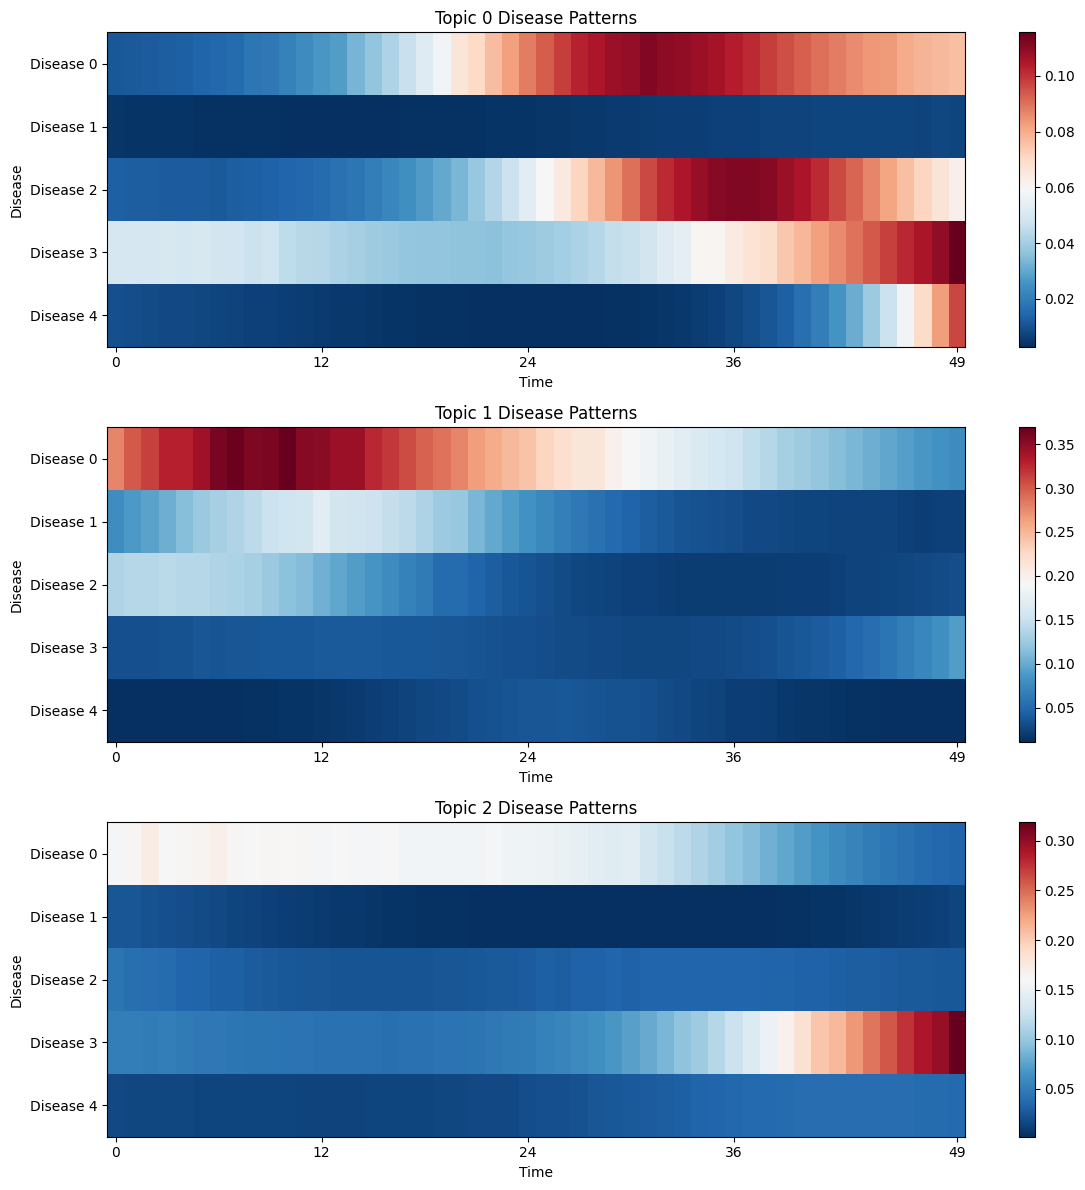

In [17]:
pi_pred, theta_pred, phi_pred = model.forward()
plot_phi_heatmaps(phi_pred, K, D, T)

In [53]:
def plot_theta_heatmaps(theta_pred, N, K, T, num_individuals=20):
    """
    Plot heatmaps of theta (topic weights) for a subset of individuals
    
    Parameters:
    theta_pred: torch tensor (N×K×T)
    N: number of individuals
    K: number of topics
    T: number of time points
    num_individuals: number of random individuals to plot
    """
    theta_np = theta_pred.detach().numpy()
    
    # Select random individuals if more than num_individuals
    if N > num_individuals:
        selected_idx = np.random.choice(N, num_individuals, replace=False)
        theta_subset = theta_np[selected_idx]
    else:
        selected_idx = np.arange(N)
        theta_subset = theta_np
    
    # Create subplots for each topic
    fig, axes = plt.subplots(K, 1, figsize=(15, 4*K))
    if K == 1:
        axes = [axes]
    
    for k in range(K):
        # Create heatmap for topic k
        im = axes[k].imshow(theta_subset[:, k, :], aspect='auto', cmap='viridis')
        plt.colorbar(im, ax=axes[k])
        
        # Add labels
        axes[k].set_title(f'Topic {k} Weights Across Individuals')
        axes[k].set_xlabel('Time')
        axes[k].set_ylabel('Individual')
        
        # Add individual numbers
        axes[k].set_yticks(range(len(selected_idx)))
        axes[k].set_yticklabels([f'Individual {i}' for i in selected_idx])
        
        # Add time ticks
        time_ticks = np.linspace(0, T-1, 5, dtype=int)
        axes[k].set_xticks(time_ticks)
        axes[k].set_xticklabels(time_ticks)
    
    plt.tight_layout()
    plt.show()

def plot_theta_comparison_heatmaps(true_theta, theta_pred, N, K, T, num_individuals=20):
    """
    Plot true vs predicted theta heatmaps side by side
    """
    theta_pred_np = theta_pred.detach().numpy()
    
    # Select random individuals
    if N > num_individuals:
        selected_idx = np.random.choice(N, num_individuals, replace=False)
        true_subset = true_theta[selected_idx]
        pred_subset = theta_pred_np[selected_idx]
    else:
        selected_idx = np.arange(N)
        true_subset = true_theta
        pred_subset = theta_pred_np
    
    fig, axes = plt.subplots(K, 2, figsize=(20, 4*K))
    
    for k in range(K):
        # True theta
        im1 = axes[k,0].imshow(true_subset[:, k, :], aspect='auto', cmap='viridis')
        plt.colorbar(im1, ax=axes[k,0])
        axes[k,0].set_title(f'True Topic {k} Weights')
        axes[k,0].set_xlabel('Time')
        axes[k,0].set_ylabel('Individual')
        
        # Predicted theta
        im2 = axes[k,1].imshow(pred_subset[:, k, :], aspect='auto', cmap='viridis')
        plt.colorbar(im2, ax=axes[k,1])
        axes[k,1].set_title(f'Predicted Topic {k} Weights')
        axes[k,1].set_xlabel('Time')
        axes[k,1].set_ylabel('Individual')
        
        # Add labels
        for ax in [axes[k,0], axes[k,1]]:
            ax.set_yticks(range(len(selected_idx)))
            ax.set_yticklabels([f'Individual {i}' for i in selected_idx])
            time_ticks = np.linspace(0, T-1, 5, dtype=int)
            ax.set_xticks(time_ticks)
            ax.set_xticklabels(time_ticks)
    
    plt.tight_layout()
    plt.show()



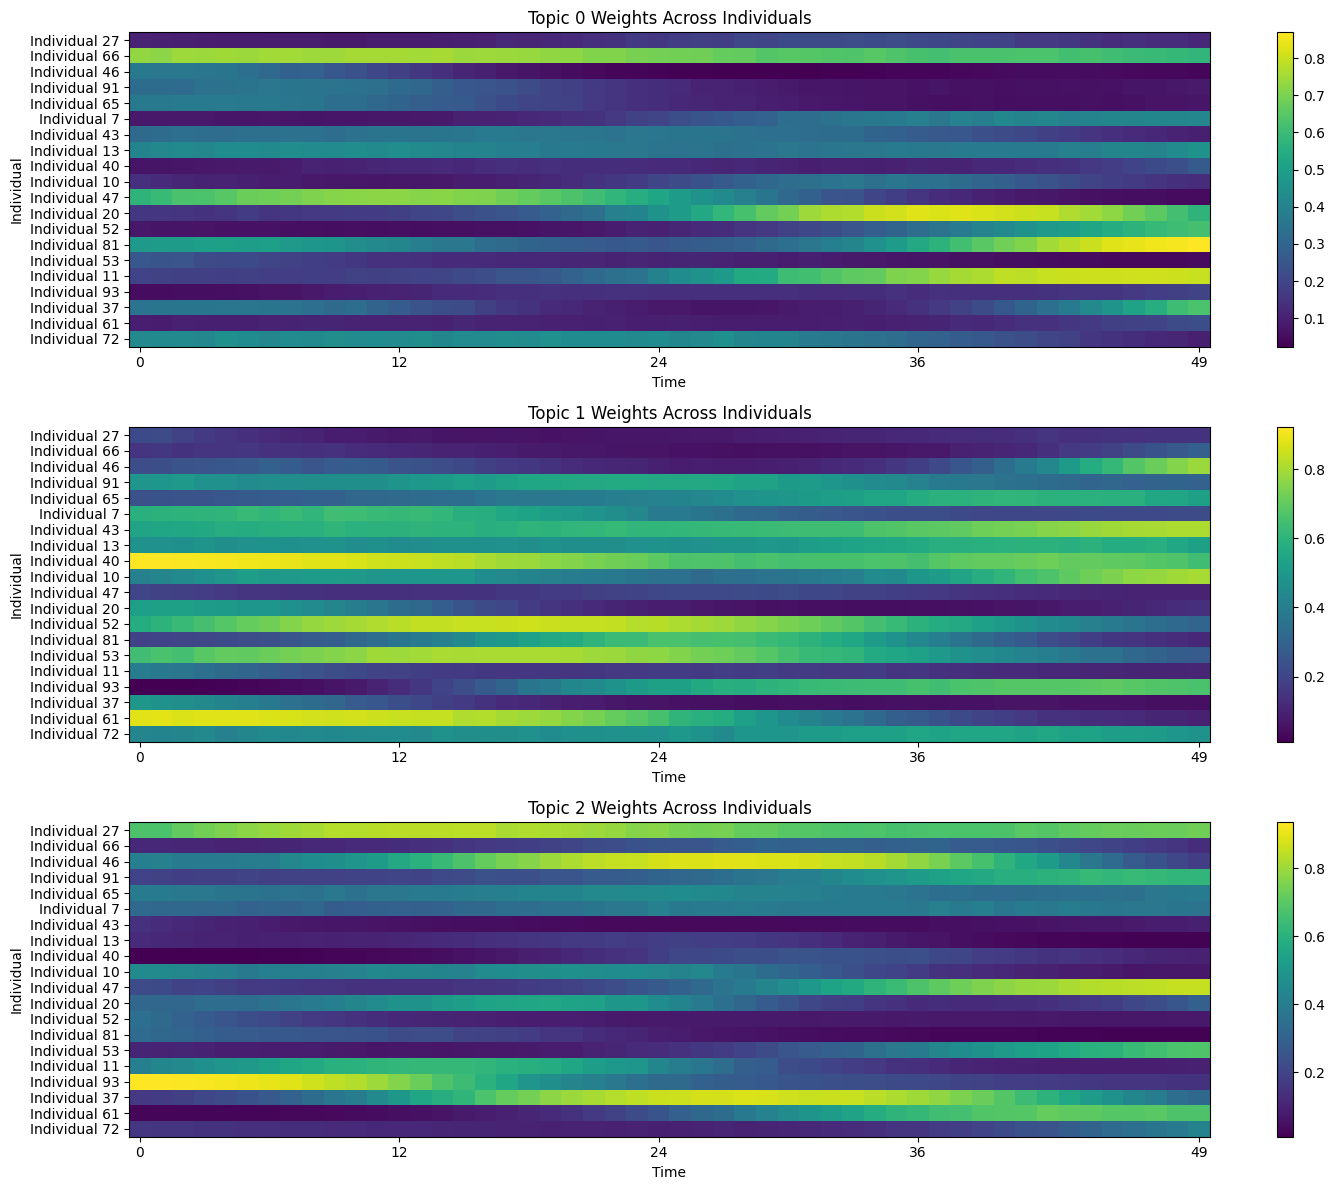

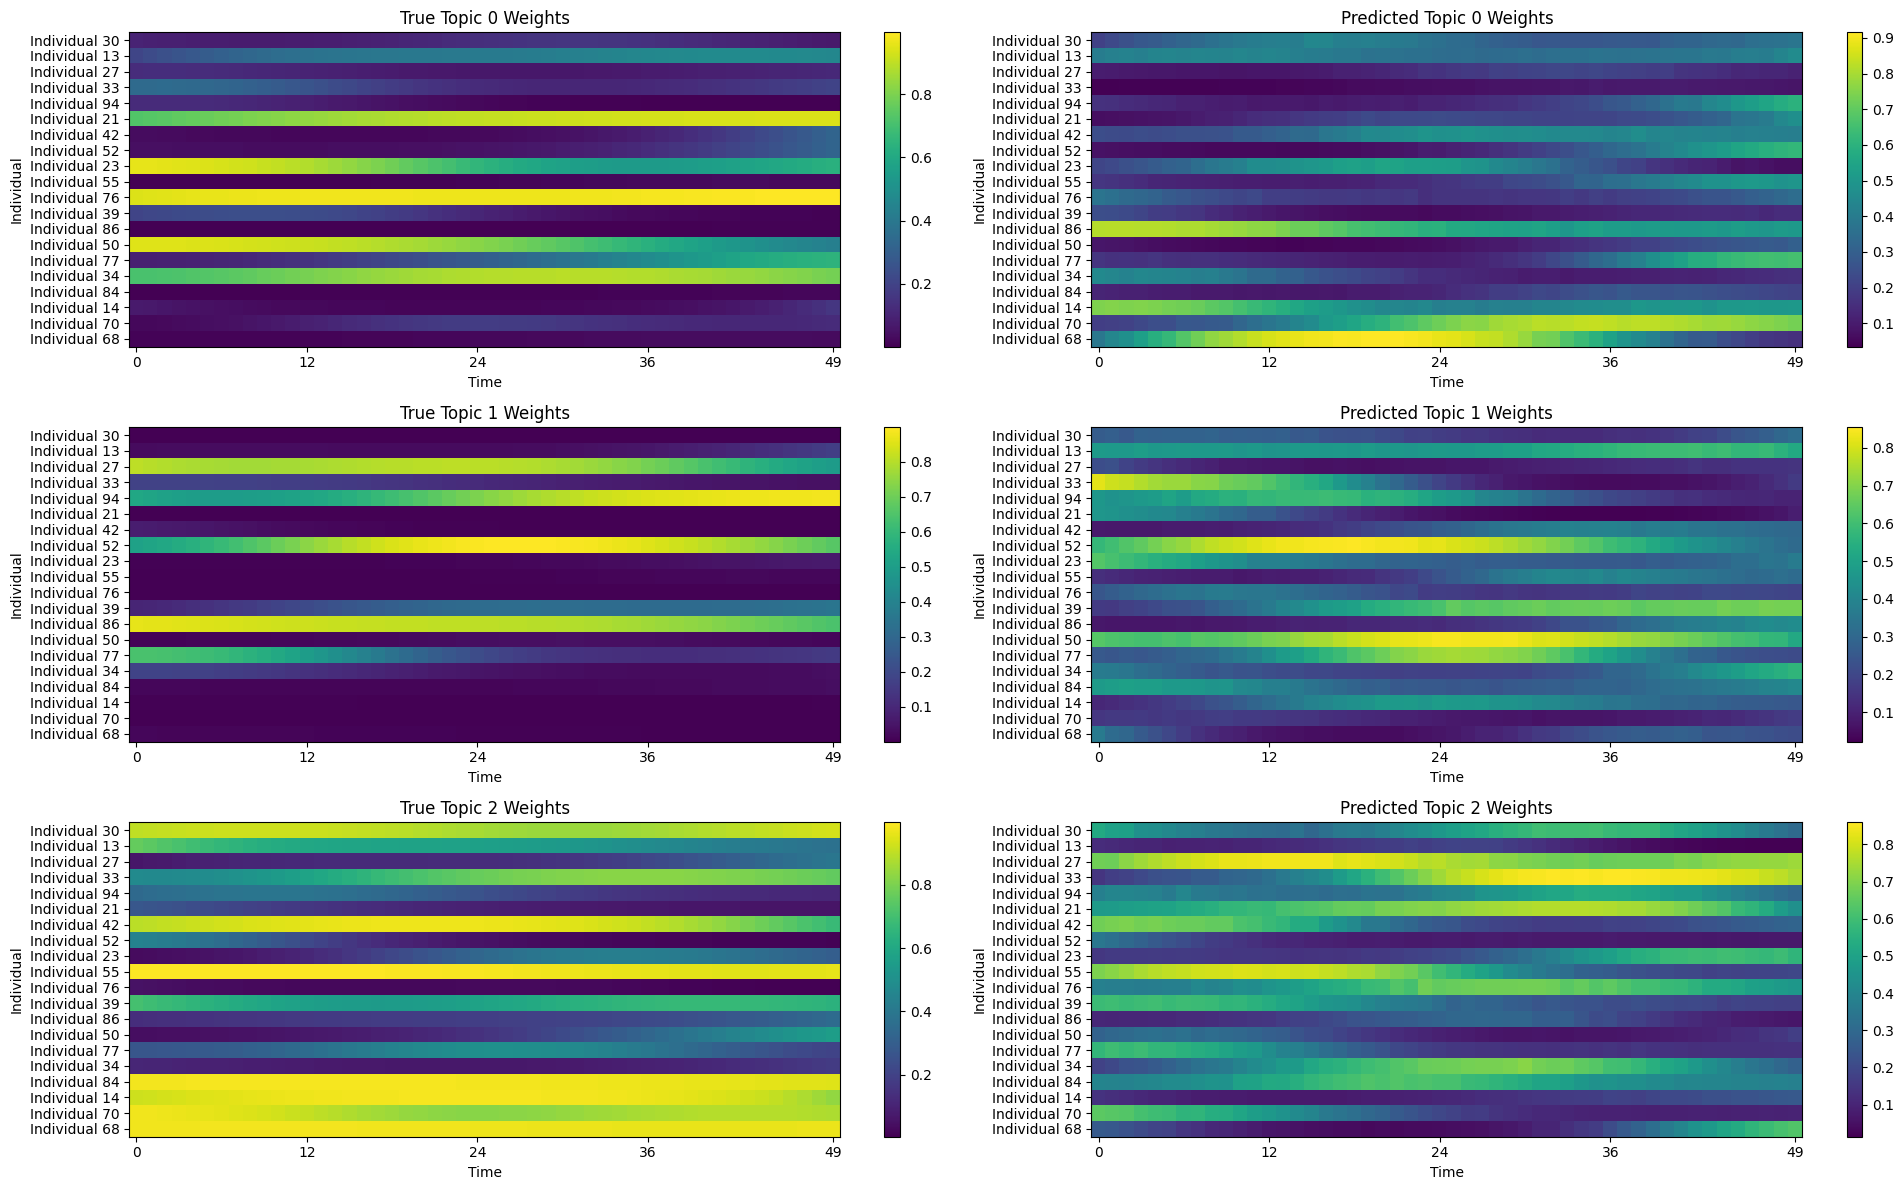

In [54]:

true_theta = true_data['theta']
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
plot_theta_heatmaps(theta_pred, N, K, T, num_individuals=20)

# Plot true vs predicted comparison
plot_theta_comparison_heatmaps(true_theta, theta_pred, N, K, T, num_individuals=20)


In [55]:
true_pi[:,:,49]

array([[0.06523936, 0.00724   , 0.06495312, 0.08511014, 0.00965726],
       [0.03957404, 0.02125382, 0.08032053, 0.00904987, 0.00926897],
       [0.21562957, 0.027126  , 0.03261847, 0.03692581, 0.07585795],
       [0.22742227, 0.02819375, 0.02980483, 0.03552769, 0.08074092],
       [0.06257828, 0.00845003, 0.06640899, 0.07840033, 0.00946473],
       [0.0496121 , 0.01875432, 0.07599707, 0.02436237, 0.01128935],
       [0.04059951, 0.02127321, 0.0800343 , 0.00928401, 0.00964754],
       [0.07258771, 0.01070477, 0.06478379, 0.0706847 , 0.0144544 ],
       [0.17260396, 0.02357337, 0.0430781 , 0.04036599, 0.05825742],
       [0.23289335, 0.02889642, 0.02861678, 0.03387531, 0.08313624],
       [0.18428566, 0.02273711, 0.03921934, 0.04815113, 0.06190748],
       [0.23253242, 0.02892081, 0.02873518, 0.03364177, 0.08302256],
       [0.192263  , 0.02595597, 0.03872858, 0.03511752, 0.06677525],
       [0.07773839, 0.01676013, 0.06671716, 0.04301337, 0.02008978],
       [0.05406396, 0.00838158, 0.

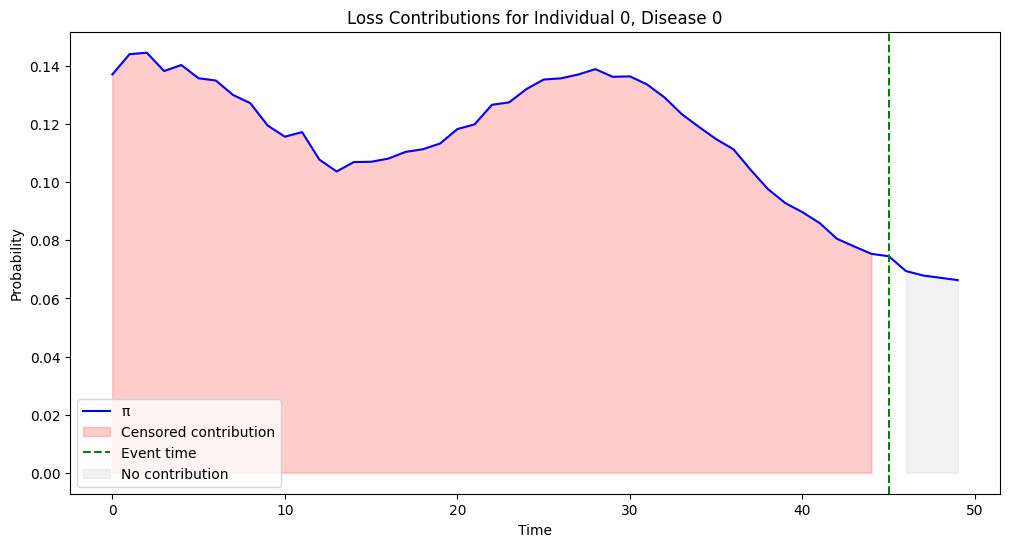

In [56]:
def plot_event_contribution(pi, event_time, Y, disease_idx=0, individual_idx=0):
    """Visualize how an event contributes to the loss"""
    T = pi.shape[-1]
    time_grid = np.arange(T)
    
    plt.figure(figsize=(12, 6))
    
    # Plot pi
    plt.plot(time_grid, pi[individual_idx, disease_idx, :].detach().numpy(), 
             label='π', color='blue')
    
    # Shade regions
    if Y[individual_idx, disease_idx, event_time] == 1:
        # Before event (censored)
        plt.fill_between(time_grid[:event_time], 0, 
                        pi[individual_idx, disease_idx, :event_time].detach().numpy(),
                        alpha=0.2, color='red', label='Censored contribution')
        
        # At event
        plt.axvline(x=event_time, color='green', linestyle='--', 
                   label='Event time')
        
        # After event (no contribution)
        plt.fill_between(time_grid[event_time+1:], 0, 
                        pi[individual_idx, disease_idx, event_time+1:].detach().numpy(),
                        alpha=0.1, color='gray', label='No contribution')
    
    plt.title(f'Loss Contributions for Individual {individual_idx}, Disease {disease_idx}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# Usage:

pi_pred, _, _ = model.forward()
plot_event_contribution(pi_pred, event_times[0,0], Y)


In [57]:
def analyze_genetic_effects(model, G):
    """
    Analyze and visualize genetic contributions
    
    Parameters:
    model: trained AladynSurvivalModel
    G: genetic covariates (N×P)
    """
    gamma_np = model.gamma.detach().numpy()  # P×K
    G_np = G.numpy() if isinstance(G, torch.Tensor) else G
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Heatmap of gamma (genetic effects per topic)
    im1 = axes[0,0].imshow(gamma_np, aspect='auto', cmap='RdBu_r')
    axes[0,0].set_title('Gamma (Genetic Effects per Topic)')
    axes[0,0].set_xlabel('Topics')
    axes[0,0].set_ylabel('Genetic Variables')
    plt.colorbar(im1, ax=axes[0,0])
    
    # 2. Distribution of genetic effects
    genetic_contribution = G_np @ gamma_np  # N×K
    for k in range(model.K):
        axes[0,1].hist(genetic_contribution[:,k], 
                      alpha=0.5, label=f'Topic {k}')
    axes[0,1].set_title('Distribution of Genetic Effects')
    axes[0,1].set_xlabel('Effect Size')
    axes[0,1].set_ylabel('Count')
    axes[0,1].legend()
    
    # 3. Genetic effect vs Topic weights
    pi_pred, theta_pred, _ = model.forward()
    theta_np = theta_pred.detach().numpy()
    
    for k in range(model.K):
        axes[1,0].scatter(genetic_contribution[:,k], 
                         theta_np[:,k,:].mean(axis=1),
                         alpha=0.5, label=f'Topic {k}')
    axes[1,0].set_title('Genetic Effect vs Average Topic Weight')
    axes[1,0].set_xlabel('Genetic Effect')
    axes[1,0].set_ylabel('Average Topic Weight')
    axes[1,0].legend()
    
    # 4. Top genetic predictors per topic
    top_n = 3
    positions = []
    labels = []
    effects_list = []
    colors = plt.cm.Set3(np.linspace(0, 1, model.K))
    
    for k in range(model.K):
        top_idx = np.argsort(np.abs(gamma_np[:,k]))[-top_n:]
        effects = gamma_np[top_idx,k]
        
        # Calculate positions for this topic
        pos = np.arange(top_n) + k*(top_n + 1)  # Add gap between topics
        positions.extend(pos)
        effects_list.extend(effects)
        labels.extend([f'Gene {i}\n(Topic {k})' for i in top_idx])
        
        # Plot bars for this topic
        axes[1,1].barh(pos, effects, color=colors[k], 
                      label=f'Topic {k}')
    
    axes[1,1].set_yticks(positions)
    axes[1,1].set_yticklabels(labels)
    axes[1,1].set_title('Top Genetic Predictors per Topic')
    axes[1,1].set_xlabel('Effect Size')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nGenetic Effect Summary:")
    for k in range(model.K):
        print(f"\nTopic {k}:")
        print("Top positive genetic effects:")
        top_pos = np.argsort(gamma_np[:,k])[-3:]
        for idx in top_pos:
            print(f"  Gene {idx}: {gamma_np[idx,k]:.3f}")
        print("Top negative genetic effects:")
        top_neg = np.argsort(gamma_np[:,k])[:3]
        for idx in top_neg:
            print(f"  Gene {idx}: {gamma_np[idx,k]:.3f}")

# Usage:
"""
analyze_genetic_effects(model, G)
"""

'\nanalyze_genetic_effects(model, G)\n'

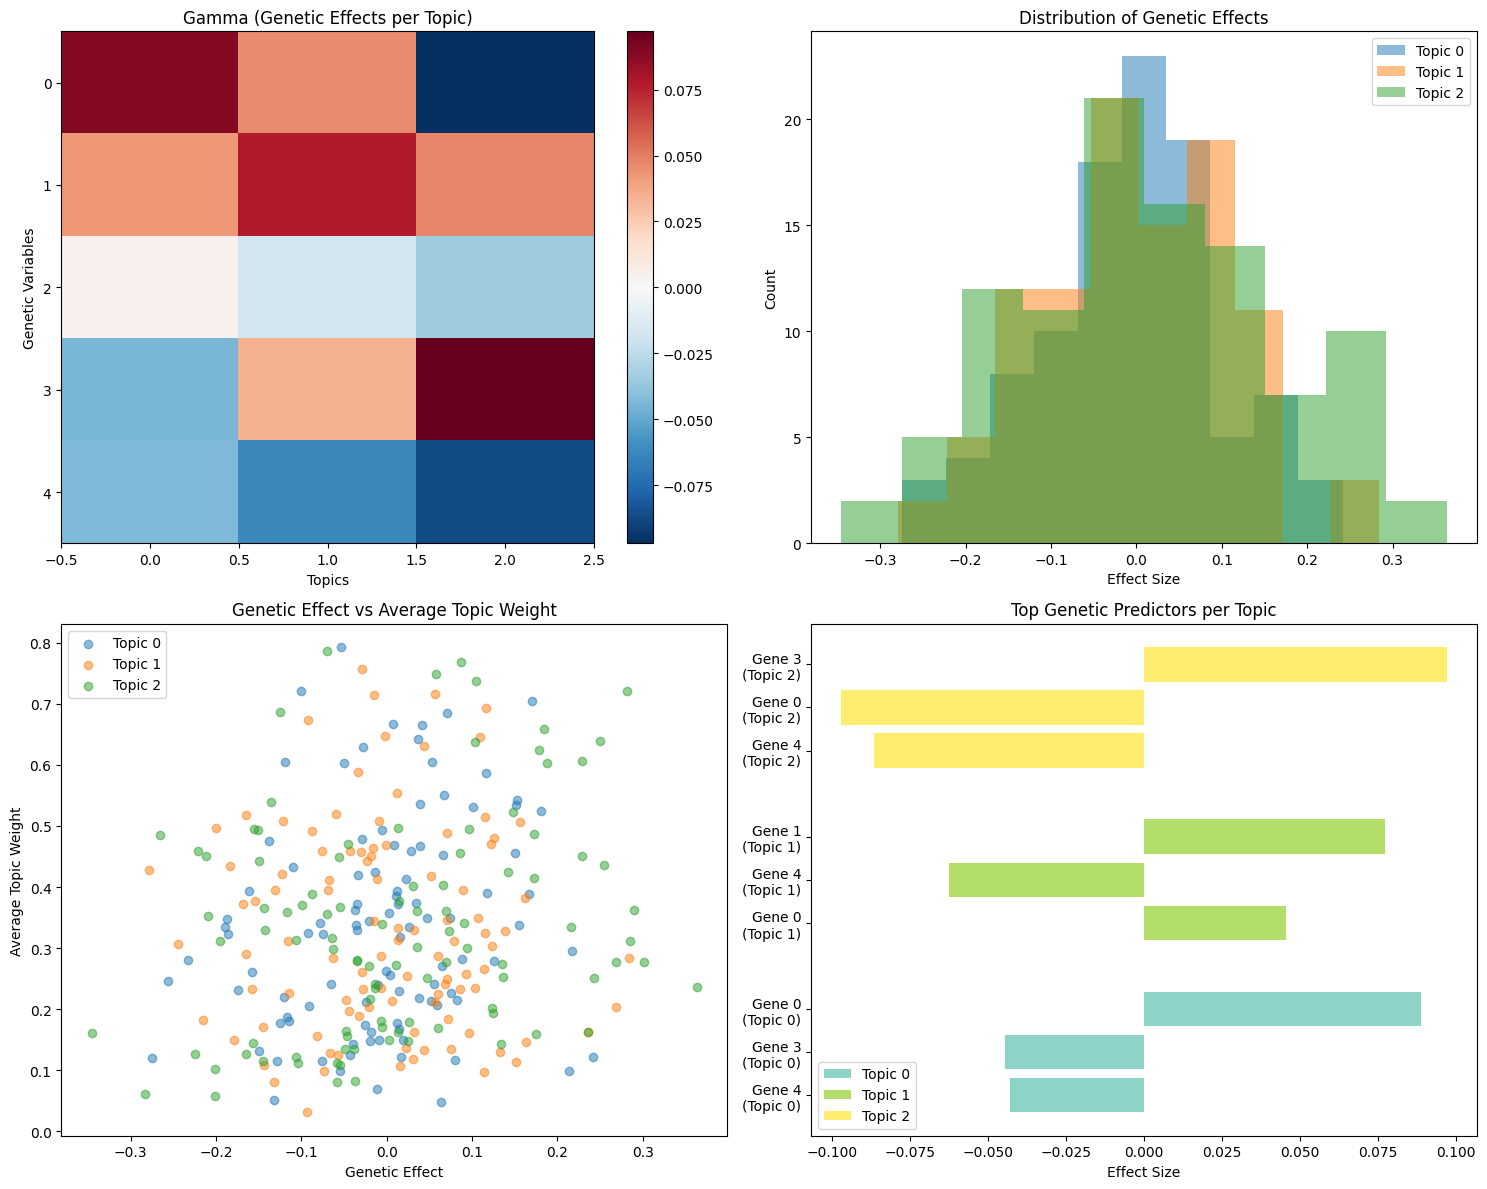


Genetic Effect Summary:

Topic 0:
Top positive genetic effects:
  Gene 2: 0.004
  Gene 1: 0.042
  Gene 0: 0.089
Top negative genetic effects:
  Gene 3: -0.045
  Gene 4: -0.043
  Gene 2: 0.004

Topic 1:
Top positive genetic effects:
  Gene 3: 0.035
  Gene 0: 0.046
  Gene 1: 0.077
Top negative genetic effects:
  Gene 4: -0.063
  Gene 2: -0.018
  Gene 3: 0.035

Topic 2:
Top positive genetic effects:
  Gene 2: -0.035
  Gene 1: 0.048
  Gene 3: 0.097
Top negative genetic effects:
  Gene 0: -0.097
  Gene 4: -0.086
  Gene 2: -0.035


In [31]:

analyze_genetic_effects(model, G)

